# DEA Waterbodies: Times Series with Sentinel-2 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_s2am_ard_3](https://explorer.dea.ga.gov.au/products/ga_s2am_ard_3), 
[ga_s2bm_ard_3](https://explorer.dea.ga.gov.au/products/ga_s2bm_ard_3),
[ga_ls5t_ard_3](https://explorer.dea.ga.gov.au/products/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.dea.ga.gov.au/products/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.dea.ga.gov.au/products/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook

## Background

It is important to have up-to-date information about the extent and location of surface water in Australia. It provides us with a common understanding of this valuable and increasingly scarce resource. In particular, it is important to be able to see how that wet surface area has changed over time for a waterbody. 

### What this product offers
DEA Waterbodies: Time Series with Sentinel-2 uses Geoscience Australia's archive of Sentinel-2A and Sentinel-2B imagery from mid-2015 onwards to describe the wet surface areas of waterbodies. DEA Waterbodies: Time Series with Sentinel-2 applies a [water classification](https://www.dea.ga.gov.au/products/dea-water-observations) for every available Sentinel-2 image for a given waterbody. It provides a time series of wet surface area for the waterbody. Historically, DEA Waterbodies has used water observations based on Landsat 5, 7, 8 and 9. By using European Space Agency's (ESA) Sentinel-2 data a higher temporal resolution is possible. The graphs indicates changes in the wet surface area of waterbodies. This can be used to identify when waterbodies are increasing or decreasing in wet surface area.



DEA Waterbodies uses a [water classification](https://www.dea.ga.gov.au/products/dea-water-observations) for every available Landsat satellite image for a pre-generated map of the locations of waterbodies across Australia. It provides a timeseries of wet surface area for waterbodies that were present more than 10% of the time between 1987-2020 and are larger than 2700 m$^2$ (3 Landsat pixels). These waterbodies have been derived from [DEA Water Observations](https://www.dea.ga.gov.au/products/dea-water-observations), a classifier which detects open water in Landsat pixels. 

- DEA Waterbodies can be viewed on the mapping portal [DEA Maps](https://maps.dea.ga.gov.au/#share=s-3ECq9avqVD8TopthD0gWnBnA3G9).



### Applications
* Understand and manage water across Australia
* Gain insights into the severity and spatial distribution of drought

### Publications
* *DEA Waterbodies v3.0*<br> Dunn, B., Krause, C., Newey, V., Lymburner, L., Alger, M.J., Adams, C., Yuan, F., Ma, S., Barzinpour, A., Ayers, D., McKenna, C., Schenk, L. 2024. Digital Earth Australia Waterbodies v3.0. Geoscience Australia, Canberra. https://dx.doi.org/10.26186/148920 
* *DEA Waterbodies* <br> Krause, C.E., Newey, V., Alger, M.J. and Lymburner, L., (2021). Mapping and monitoring the multi-decadal dynamics of Australia’s open waterbodies using Landsat. Remote Sensing, 13(8), p.1437. https://doi.org/10.3390/rs13081437
* *DEA Water Observations* <br>Mueller, N., Lewis, A., Roberts, D., Ring, S., Melrose, R., Sixsmith, J., Lymburner, L., McIntyre, A., Tan, P., Curnow, S., & Ip, A. (2016). Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia. *Remote Sensing of Environment*, 174, 341–352. https://doi.org/10.1016/j.rse.2015.11.003

> **Note:** For more technical information about DEA Waterbodies, visit the official [Geoscience Australia DEA Waterbodies product description](https://knowledge.dea.ga.gov.au/data/product/dea-waterbodies-landsat).

## Description

This notebook will demonstrate how to load Sentinel-2 imagery and apply a water classification to produce a wet surface area time series for a given waterbody. Topics covered include:

1. Loading Sentinel-2 imagery.
2. Running WOs on Sentinel-2 imagery for Lake Victoria on all available times.
3. Producing a wet surface area time series using Sentinel-2.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
#%%bash
#pip install ephem
#pip install --index-url https://packages.dea.ga.gov.au/ wofs

In [2]:
import csv
from pathlib import Path
import warnings

import datacube
import geopandas as gpd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import rasterio
import rioxarray
import scipy.optimize as opt

import sys
sys.path.insert(1, "../Tools/")
from dea_tools import waterbodies
from dea_tools.spatial import xr_rasterize
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, plot_wo, display_map
from dea_tools import S2_wofls
from dea_tools.waterbodies import (
    get_geohashes,
    get_waterbodies,
    get_waterbody,
    get_time_series,
)

import rioxarray

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
# Set up the datacube:
dc = datacube.Datacube(app="WaterbodyTimeSeriesS2")

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


## Getting data

Every waterbody in DEA Waterbodies has a unique identifier called a [geohash](https://en.wikipedia.org/wiki/Geohash). The geohash of a waterbody is derived from their position, and this process can be reversed to obtain the location from the geohash. You can also get the geohash for a waterbody from [DEA Maps](http://maps.dea.ga.gov.au/) by clicking on a waterbody. It's the "waterbody identifier" in this screenshot:

![image.png](../Supplementary_data/DEA_Waterbodies/waterbodiesv3_nb_ex.JPG)

The `dea_waterbodies` module allows you to query waterbodies by geohash or by location.

### Getting data for a specific waterbody

We can use a geohash to get the polygon for an individual waterbody. For example, we can load data for Lake Victoria in New South Wales using its geohash `r1uqwu1tj_v3`.

In [4]:
geohash = "r1uqwu1tj_v3"

In [5]:
# Load the waterbody shape:
shape = waterbodies.get_waterbody(geohash)

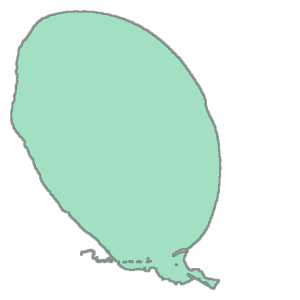

In [6]:
shape.geometry[0]

Sentinel 2 data is available from 2015-07-12. For more information refer to the DEA Sentinel 2 notebook [LINK]

In [7]:
# Select the time period
time_period = ("2015-08-01", "2017-01-01")

## Loading Sentinel-2 data

Load Sentinel-2A and Sentinel-2B data. By specifying `output_crs="EPSG:3577"` and `resolution=(-10, 10)`, we request the datacube reprojects our data to the Australian Albers coordinate reference system (CRS), with 10 x 10 m pixels. Further, `geopolygon=datacube.utils.geometry.Geometry(shape.geometry[0].buffer(100), crs="EPSG:3577")` specifies the CRS of the polygon. 

In [8]:
ds = load_ard(
    dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    resolution=(-10, 10),
    output_crs="EPSG:3577",
    min_gooddata=0.9,
    geopolygon=datacube.utils.geometry.Geometry(
        shape.geometry[0].buffer(100), crs="EPSG:3577"
    ),
    time=time_period,
)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 31 out of 82 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 31 time steps


We can now view the data that we loaded. 

In [9]:
# Load into memory using Dask
ds.load()

<xarray.Dataset> Size: 5GB
Dimensions:                     (time: 31, y: 1487, x: 1127)
Coordinates:
  * time                        (time) datetime64[ns] 248B 2015-10-02T00:34:2...
  * y                           (y) float64 12kB -3.734e+06 ... -3.749e+06
  * x                           (x) float64 9kB 8.46e+05 8.46e+05 ... 8.572e+05
    spatial_ref                 int32 4B 3577
Data variables: (12/27)
    nbart_coastal_aerosol       (time, y, x) float32 208MB 594.0 594.0 ... 265.0
    nbart_blue                  (time, y, x) float32 208MB 610.0 615.0 ... 222.0
    nbart_green                 (time, y, x) float32 208MB 768.0 749.0 ... 308.0
    nbart_red                   (time, y, x) float32 208MB 969.0 959.0 ... 251.0
    nbart_red_edge_1            (time, y, x) float32 208MB 1.191e+03 ... 339.0
    nbart_red_edge_2            (time, y, x) float32 208MB 1.41e+03 ... 414.0
    ...                          ...
    oa_solar_zenith             (time, y, x) float32 208MB 39.91 39.91 ... 28.27
    oa_time_delta               (time, y, x) float32 208MB 5.329 5.329 ... 6.486
    oa_s2cloudless_mask         (time, y, x) float32 208MB 1.0 1.0 ... 1.0 1.0
    oa_s2cloudless_prob         (time, y, x) float32 208MB 0.04014 ... 0.04335
    oa_fmask                    (time, y, x) uint8 52MB 1 1 1 1 1 ... 5 5 5 5 5
    oa_nbart_contiguity         (time, y, x) uint8 52MB 1 1 1 1 1 ... 1 1 1 1 1
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

We can plot the data we loaded using the `rgb` function. By default, the function will plot data as a true colour image using the `'nbart_red', 'nbart_green', 'nbart_blue'` bands.

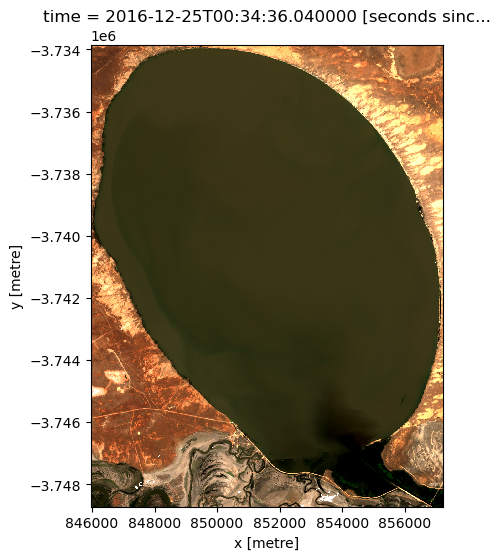

In [10]:
# Plot the last time step
rgb(ds.isel(time=-1))

## Run WOs

We will run WOs on the Sentinel-2 images, ignoring any potential correction factors we might want to make to the Sentinel-2 bands. This is a fairly naive approach!

First we need a DEM. To run this on DEA Sandbox, we'll use a DEM downloaded from ELVIS and processed in QGIS.

In [11]:
# Open the DEM, which is in EPSG:3577
dem = rioxarray.open_rasterio("lakevictoria.tif")

# define nodata values
nodata = dem.rio.nodata

In [12]:
# Screen out no-data
dem = dem.where(dem != nodata)

In [13]:
# Set zero pixels (water) to the minimum to avoid edge effects in WOs terrain shadows
dem.isel(band=0).values[(dem == 0).values[0]] = dem.where(dem > 0).min()

In [14]:
# Convert into an xarray dataset for WOs
dem = xr.Dataset({"elevation": dem.isel(band=0)})

In [15]:
# Set nodata attrs
ds.attrs["nodata"] = np.nan
for band in ds.variables:
    ds[band].attrs["nodata"] = np.nan

In [16]:
# Set CRS attrs
dem.attrs["crs"] = "EPSG:3577"

In [17]:
# Reproject the DEM
transform, width, height = rasterio.warp.calculate_default_transform(
    "EPSG:3577", "EPSG:3577", dem.rio.width, dem.rio.height, *dem.rio.bounds()
)

### Unsure what is going on

In [18]:
dem_reproj = rasterio.warp.reproject(
    source=dem.elevation,
    src_transform=dem.rio.transform(),
    src_crs=dem.crs,
    destination=ds.rename({"nbart_blue": "elevation"}).elevation.isel(time=0).copy(),
    dst_transform=ds.rio.transform(),
    dst_crs=ds.crs,
    resampling=rasterio.warp.Resampling.bilinear,
)[0]

In [19]:
# create the cloud mask
#fmask = ds.oa_fmask
#print(fmask)
#shape = fmask.shape
#print(shape)

In [20]:
#test = ds.isel(time=0)
#ard = test

#fmask = test.oa_fmask
#print(fmask)
#shape = fmask.shape
#print(shape)

Then we can run WOfS on each image, producing Sentinel 2 WOfLS.

In [21]:
s2_wofls = []
for i in tqdm(range(len(ds.time))):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s2_wofls_ = S2_wofls.woffles_ard(
            ds.rename(
                {
                    "nbart_nir_1": "nbart_nir",
                    "nbart_swir_2": "nbart_swir_1",
                    "nbart_swir_3": "nbart_swir_2",
                }
            ).isel(time=i),
            xr.Dataset({"elevation": dem_reproj}, attrs={"crs": "EPSG:3577"}),
        )
        s2_wofls.append(s2_wofls_)

  0%|          | 0/31 [00:00<?, ?it/s]

In [22]:
s2_wofs = xr.concat(s2_wofls, dim="time")

## Masking

1. Use the [Function of Mask (Fmask)](https://knowledge.dea.ga.gov.au/guides/reference/analysis_ready_data_corrections/#function-of-mask-fmask) bit flags to mask `cloud` and `shadow` and select all clear pixels, i.e. `valid`, `water`, `snow`. 
1. From these masked pixels, use the [Water Observations](https://knowledge.dea.ga.gov.au/data/product/dea-water-observations-landsat/?tab=details#technical-information) decimal value to select clear pixels, i.e. `water observed` (wet) and `no water detected` (dry) pixels.

In [23]:
# Apply cloud masking:
fmask = (ds["oa_fmask"] == 1) | (ds["oa_fmask"] == 5) | (ds["oa_fmask"] == 4)

In [24]:
# Select all clear pixels:
s2_wofs = s2_wofs.where(((s2_wofs == 128) | (s2_wofs == 0)) & fmask)

Finally we can convert to boolean and view the results.

In [25]:
s2_wofs = (s2_wofs == 128).where(~s2_wofs.isnull())

Display some of the masked time steps for Lake Victoria. Yellow represents clear water pixels, purple represents dry pixels and white are areas which have been masked out by being set to . [CHECK]


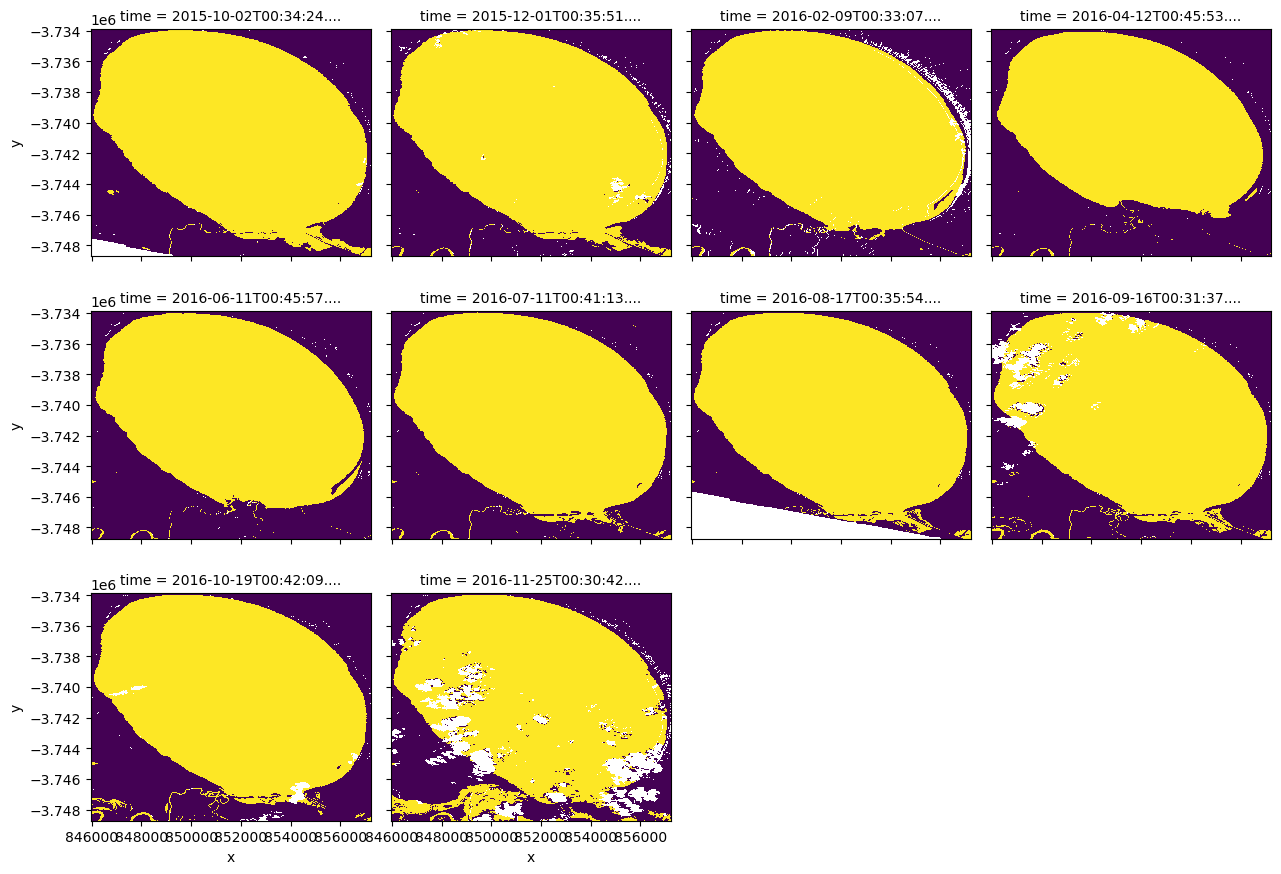

In [26]:
s2_wofs.isel(time=range(0, 30, 3)).astype(float).plot(
    col="time", col_wrap=4, add_colorbar=False
)

## Extract the time series

Next we apply the waterbody as a mask. To create a mask we rasterize the dataset using [`xr_rasterize`](https://knowledge.dea.ga.gov.au/notebooks/Tools/gen/dea_tools.spatial/#dea_tools.spatial.xr_rasterize). This creates a mask of the waterbody polygon defined earlier in the notebook.

In [27]:
# Convert the shape into a raster mask:
mask = xr_rasterize(gdf=shape, da=s2_wofs)

In [28]:
# Apply the mask:
s2_wofs_masked = s2_wofs.where(mask)

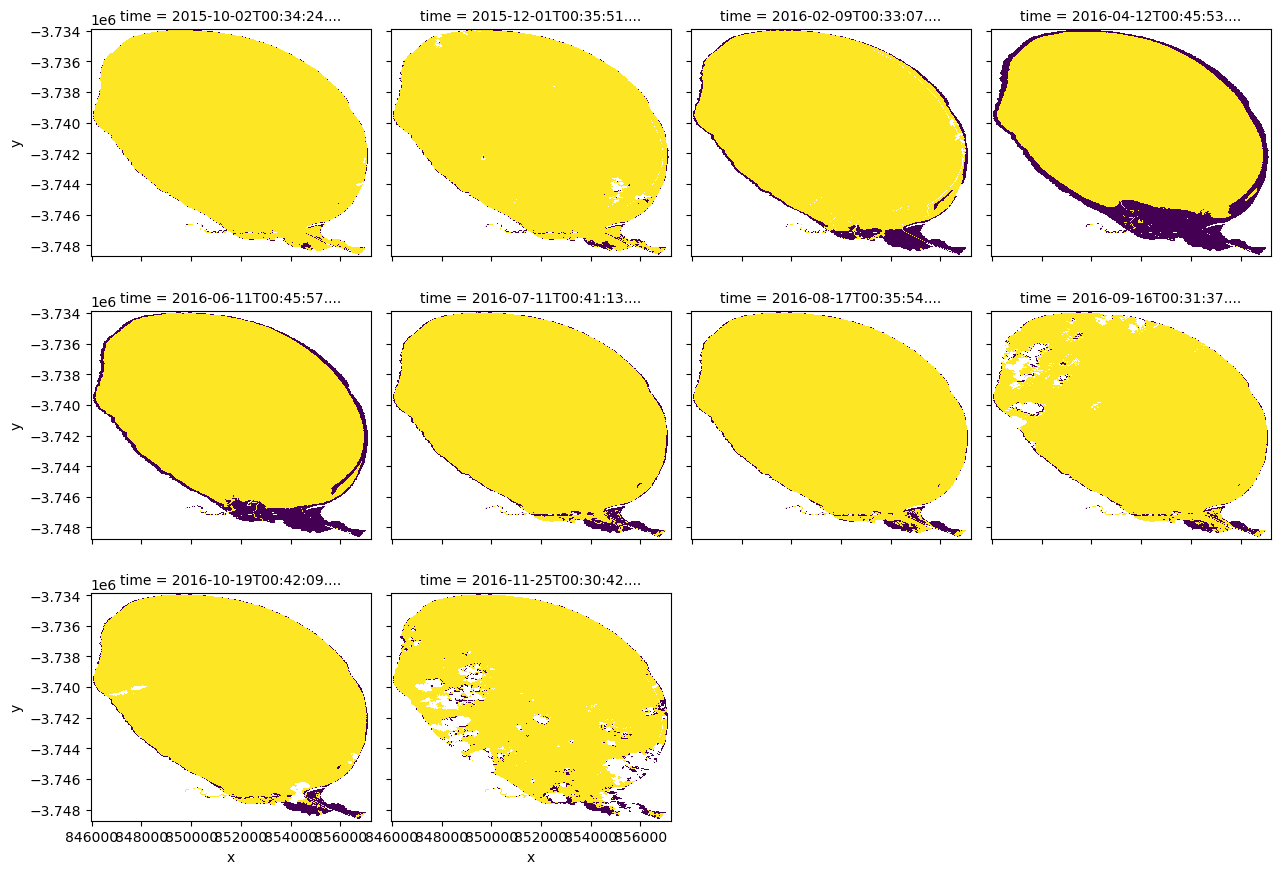

In [29]:
# Visualise the results
s2_wofs_masked.isel(time=range(0, 30, 3)).astype(float).plot(
    col="time", col_wrap=4, add_colorbar=False
)

The time series is the sum of valid pixels.

In [30]:
ts_sa_s2 = s2_wofs_masked.sum(dim=["x", "y"])

Apply a filter that excludes scenes with less than 90% valid pixels. Count how many pixels are missing compared to how many pixels are in the mask:

In [31]:
masked_pixel_counts = s2_wofs_masked.isnull().sum(dim=["x", "y"])
n_masked_pixels = (1 - mask).sum()
missing_pixel_counts = masked_pixel_counts - n_masked_pixels

In [32]:
# Convert to a percentage of the maximum extent
missing_pixel_pcs = missing_pixel_counts / mask.sum()

In [33]:
# Apply the filter
ts_sa_s2 = ts_sa_s2.sel(time=missing_pixel_pcs <= 0.1)

We can also estimate the upper bound as the measured value plus the number of missing pixels.

In [34]:
upper_bound = ts_sa_s2 + missing_pixel_counts

One frame seems to be missing all pixels, so we will exclude it.

In [35]:
upper_bound = upper_bound.sel(time=ts_sa_s2 > 0)
ts_sa_s2 = ts_sa_s2.sel(time=ts_sa_s2 > 0)

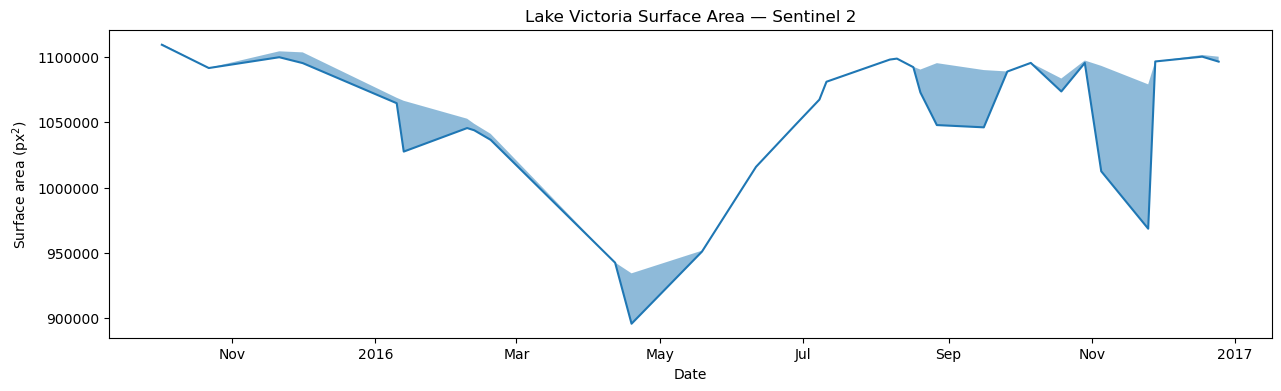

In [36]:
plt.figure(figsize=(15, 4))
plt.fill_between(ts_sa_s2.time.values, ts_sa_s2, upper_bound, alpha=0.5 )
ts_sa_s2.plot()
plt.title("Lake Victoria Surface Area — Sentinel 2")
plt.xlabel("Date")
plt.ylabel("Surface area (px$^2$)")

# Format y-axis tick labels to 3 significant figures
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.12g'))

# Show the plot
plt.show()

## Compare to Landsat time series 

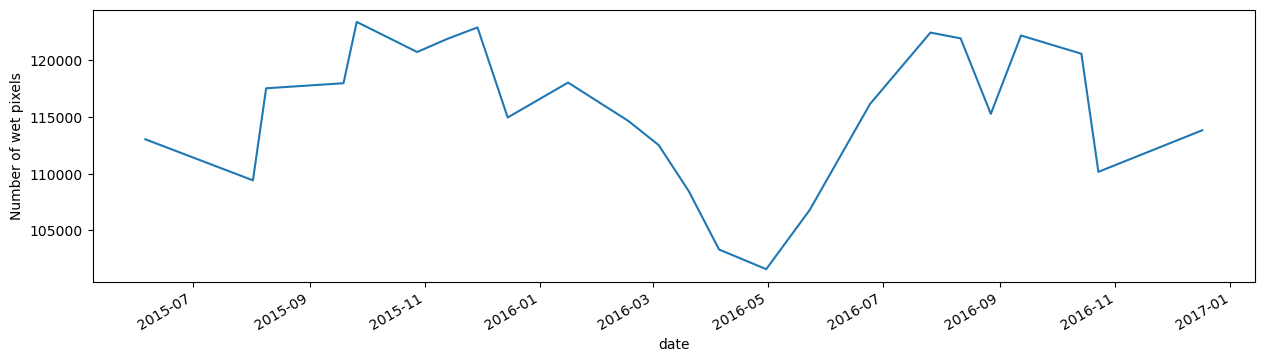

In [37]:
plt.figure(figsize=(15, 4))
get_time_series(geohash="r1uqwu1tj_v3")["px_wet"].iloc[458:482].plot()
plt.ylabel("Number of wet pixels");

In [38]:
df = ts_sa_s2.to_dataframe(name="px_wet")
df.index = df.index.tz_localize("UTC")
ts_sa_s2 = df

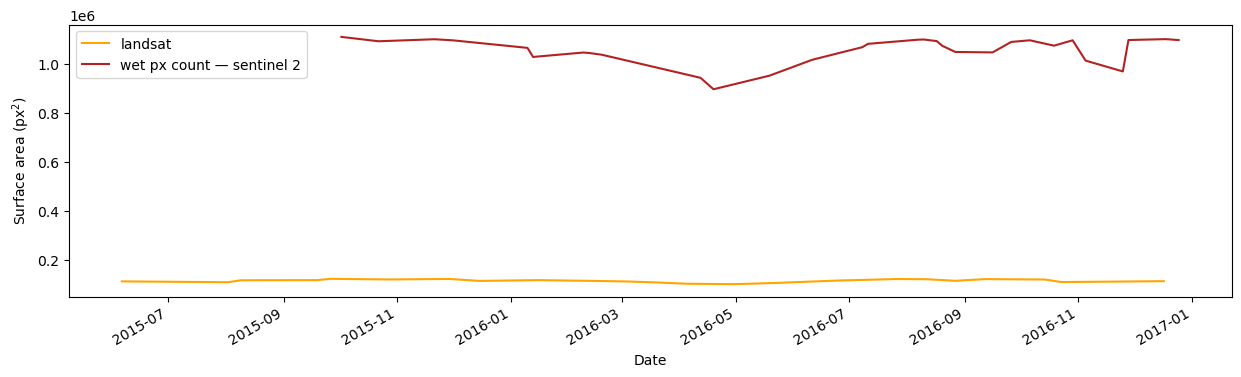

In [39]:
plt.figure(figsize=(15, 4))
get_time_series(geohash="r1uqwu1tj_v3")["px_wet"].iloc[458:482].plot(label="landsat", c='orange')
ts_sa_s2.px_wet.plot(
    label="wet px count — sentinel 2", c="firebrick"
)
#plt.xlim(ts_sa_s2.index[0], ts_vol.index[-1])
plt.ylabel("Surface area (px$^2$)")
plt.xlabel("Date")
plt.legend();